In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.regularizers import l2
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Load Data

In [2]:
df = pd.read_csv('../dataset/face/fer2013.csv')
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [3]:
train = df[df.Usage == 'Training']
test = df[df.Usage == 'PrivateTest']
val = df[df.Usage == 'PublicTest']

In [4]:
print('train: {}'.format(len(train)))
print('test: {}'.format(len(test)))
print('validation: {}'.format(len(val)))

train: 28709
test: 3589
validation: 3589


# Build X sets

In [5]:
def build_X(data):
    res = np.zeros((len(data), 48, 48, 1)).astype('float32')

    for i in range(len(data)):
        pixl = data.iloc[i,:].pixels.split(' ')
        pixels = np.array(pixl).astype('float32') / 255.
        pixels = pixels.reshape(48, 48, 1)
        res[i] = pixels
    
    return res

In [6]:
X_train = build_X(train)
X_test = build_X(test)
X_val = build_X(val)

# Build Y sets
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In [8]:
# One Hot Encoding 7 categories
Y_train = np_utils.to_categorical(train.emotion.values, 7)
Y_test = np_utils.to_categorical(test.emotion.values, 7)
Y_val = np_utils.to_categorical(val.emotion.values, 7)

In [9]:
Y_train[:3]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]])

# Print Images

In [10]:
def print_img(row, col, target, idx):
    fig = plt.figure(figsize=(col*2.5, row*2.5))
    
    for i in range(len(idx)):
        plt.subplot(row, col, (i+1))
        plt.imshow(target[idx[i]].reshape((48, 48)), cmap='gray')
        plt.grid(False); plt.xticks([]); plt.yticks([]);
    
    plt.show()

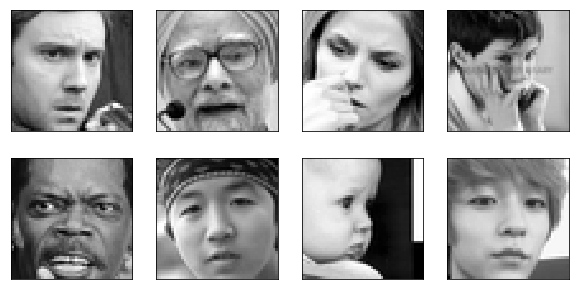

In [11]:
print_img(row=2, col=4, target=X_train, idx=[0, 1, 2, 3, 10, 11, 12, 13])

# Not Face Samples

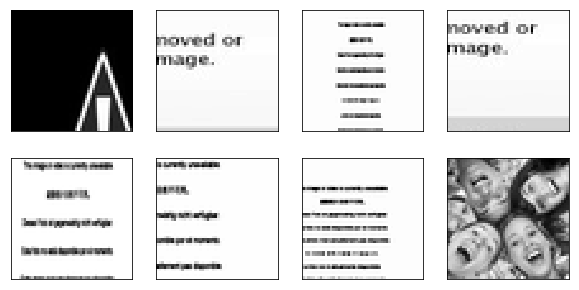

In [12]:
print_img(row=2, col=4, target=X_train, idx=[59, 2059, 2809, 3262, 3931,4275, 5439, 5509])

In [13]:
train_not_face = [59, 2059, 2809, 3262, 3931,4275, 5439, 5509, 5722, 5881, 6102, 6458, 6699, 7172,
 7496, 7527, 7629, 8030, 8737, 8856, 9026, 9500, 9673, 9679, 9693, 9797, 10023,
 10423, 10657, 11244, 11286, 11295, 11846, 12289, 12352, 13011, 13148, 13402, 13697,
 13839, 13988, 14148, 14279, 15144, 15553, 15838, 15894, 16024, 16540, 17081, 17620,
 18012, 18337, 19238, 19422, 19632, 20222, 20712, 20817, 21817, 22198,
 22407, 22927, 23596, 23894, 24053, 24441, 14593, 24891, 25219, 25603, 25909, 26383,
 26860, 26897, 28601, 19447]

In [14]:
train1 = train.drop(train_not_face, axis=0)

In [15]:
print('train: {}'.format(len(train)))
print('train1: {}'.format(len(train1)))

train: 28709
train1: 28632


In [16]:
X_train1 = build_X(train1)
Y_train1 = np_utils.to_categorical(train1.emotion.values, 7)

# Image Augmentation

In [119]:
def check_generator(X, Y, arg):
    datagen = arg
    datagen.fit(X)
    
    # configure batch size and retrieve one batch of images
    for X_batch, Y_batch in datagen.flow(X, Y, batch_size=8, shuffle=False):
        break
    print_img(row=1, col=8, target=X_batch, idx=[0, 1, 2, 3, 4, 5, 6, 7])

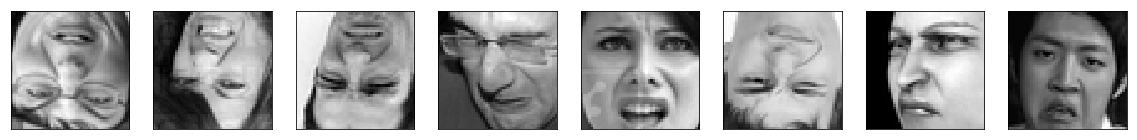

In [120]:
check_generator(X1, Y1, ImageDataGenerator(vertical_flip=True))

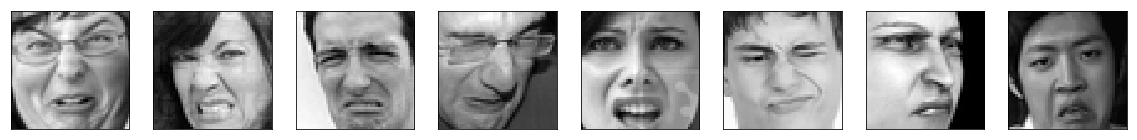

In [121]:
check_generator(X1, Y1, ImageDataGenerator(horizontal_flip=True))

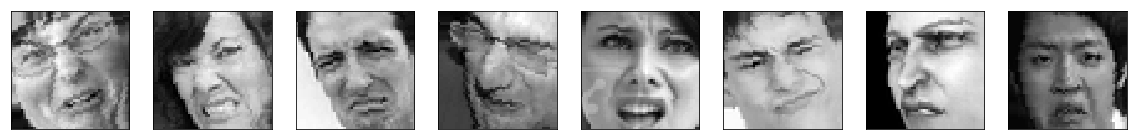

In [122]:
check_generator(X1, Y1, ImageDataGenerator(rotation_range=20))

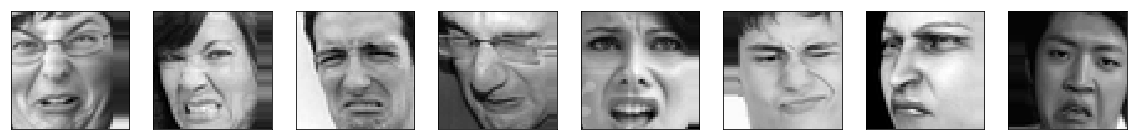

In [123]:
check_generator(X1, Y1, ImageDataGenerator(width_shift_range=0.2))

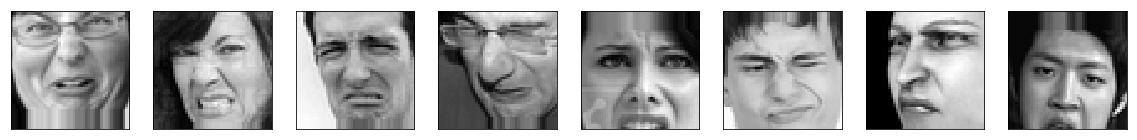

In [124]:
check_generator(X1, Y1, ImageDataGenerator(height_shift_range=0.2))

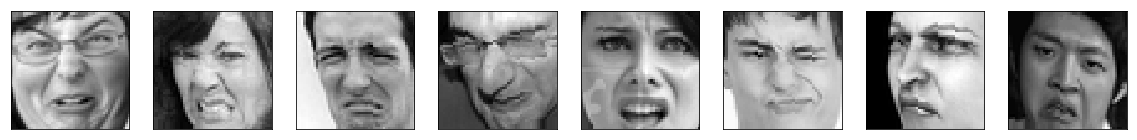

In [125]:
check_generator(X1, Y1, ImageDataGenerator(shear_range=0.2))

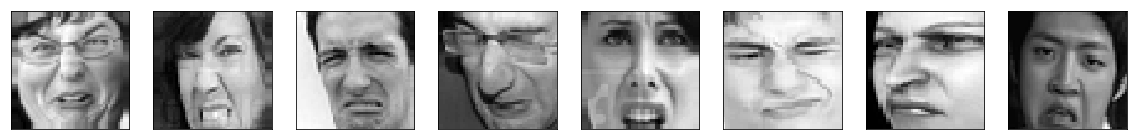

In [126]:
check_generator(X1, Y1, ImageDataGenerator(zoom_range=[0.7, 1.3]))

# Imbalanced Training Samples

In [17]:
train1.groupby(['emotion']).count()

,pixels,Usage
emotion,,
0,3980,3980
1,435,435
2,4090,4090
3,7196,7196
4,4818,4818
5,3161,3161
6,4952,4952


In [18]:
t1 = train1[train1.emotion == 1]
t1.tail()

,emotion,pixels,Usage
28260,1,41 38 40 34 29 39 34 50 109 184 220 231 233 23...,Training
28332,1,53 64 78 81 81 81 80 79 78 77 78 80 82 85 87 9...,Training
28390,1,2 0 85 139 197 220 219 225 229 231 232 230 225...,Training
28598,1,22 20 18 21 38 48 55 58 59 66 73 84 93 94 91 8...,Training
28650,1,228 173 153 154 145 112 79 66 112 179 199 210 ...,Training


In [19]:
X1 = build_X(t1)
Y1 = np_utils.to_categorical(t1.emotion.values, 7)

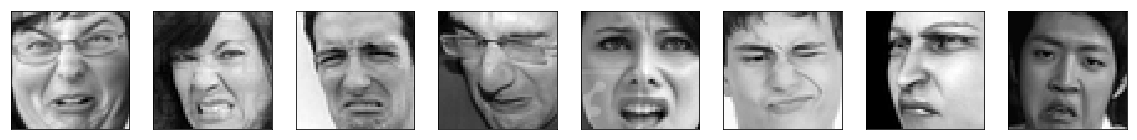

In [20]:
print_img(row=1, col=8, target=X1, idx=[0, 1, 2, 3, 4, 5, 6, 7])

# Build Category1 with image augmentation

In [21]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=[0.9, 1.1]
    )
datagen.fit(X1)

In [22]:
X = X1.copy()
Y = Y1.copy()

for i in range(6):
    for X_batch, Y_batch in datagen.flow(X1, Y1, batch_size=len(X1), shuffle=True):
        break
    
    X = np.vstack((X, X_batch))
    Y = np.vstack((Y, Y_batch))

In [23]:
X1.shape

(435, 48, 48, 1)

In [24]:
X.shape

(3045, 48, 48, 1)

In [25]:
Y.shape

(3045, 7)

In [133]:
train2

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [135]:
train2.emotion.unique()

array([0, 2, 4, 6, 3, 5])

In [26]:
train2 = train1[train1.emotion != 1]
X_train2 = build_X(train2)
Y_train2 = np_utils.to_categorical(train2.emotion.values, 7)

In [27]:
# Merge augmented training set of the category1(Disgust) to original Data set
X_train2 = np.vstack((X_train2, X))
Y_train2 = np.vstack((Y_train2, Y))

In [136]:
X_train2.shape

(31242, 48, 48, 1)

In [137]:
Y_train2.shape

(31242, 7)

In [34]:
X_train2.reshape(31242, 2304)[0]

2304

In [138]:
Y_train2[:10]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [38]:
dfX = pd.DataFrame(X_train2.reshape(31242, 2304))
dfY = pd.DataFrame(Y_train2)

In [139]:
dfY

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
print('Category 0: {}'.format(len(dfY[dfY[0] == 1])))
print('Category 1: {}'.format(len(dfY[dfY[1] == 1])))
print('Category 2: {}'.format(len(dfY[dfY[2] == 1])))
print('Category 3: {}'.format(len(dfY[dfY[3] == 1])))
print('Category 4: {}'.format(len(dfY[dfY[4] == 1])))
print('Category 5: {}'.format(len(dfY[dfY[5] == 1])))
print('Category 6: {}'.format(len(dfY[dfY[6] == 1])))

Category 0: 3980
Category 1: 3045
Category 2: 4090
Category 3: 7196
Category 4: 4818
Category 5: 3161
Category 6: 4952


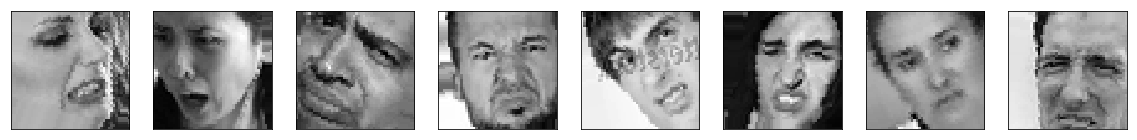

In [30]:
print_img(row=1, col=8, target=X_train2, idx=[30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007])

In [190]:
%%time
np.savetxt('../dataset/face/X_train.txt', X_train2.reshape((31242, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_train.txt', Y_train2, delimiter=',')
np.savetxt('../dataset/face/X_test.txt', X_test.reshape((3589, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_test.txt', Y_test, delimiter=',')

CPU times: user 1min 10s, sys: 1.52 s, total: 1min 11s
Wall time: 1min 20s


# Over Sampling

In [151]:
len(dfY[dfY[6] == 1].index.values)

4952

In [ ]:
t0 = train1[train1.emotion == 1]
X_train2 = build_X(train2)
Y_train2 = np_utils.to_categorical(train2.emotion.values, 7)

In [62]:
X0 = X_train2[dfY[dfY[0] == 1].index.values]
X1 = X_train2[dfY[dfY[1] == 1].index.values]
X2 = X_train2[dfY[dfY[2] == 1].index.values]
X3 = X_train2[dfY[dfY[3] == 1].index.values]
X4 = X_train2[dfY[dfY[4] == 1].index.values]
X5 = X_train2[dfY[dfY[5] == 1].index.values]
X6 = X_train2[dfY[dfY[6] == 1].index.values]

In [63]:
Y0 = Y_train2[dfY[dfY[0] == 1].index.values]
Y1 = Y_train2[dfY[dfY[1] == 1].index.values]
Y2 = Y_train2[dfY[dfY[2] == 1].index.values]
Y3 = Y_train2[dfY[dfY[3] == 1].index.values]
Y4 = Y_train2[dfY[dfY[4] == 1].index.values]
Y5 = Y_train2[dfY[dfY[5] == 1].index.values]
Y6 = Y_train2[dfY[dfY[6] == 1].index.values]

In [106]:
X0.shape

(3980, 48, 48, 1)

In [100]:
def over_sampling(X0, Y0):    
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        shear_range=0.1,
        height_shift_range=0.1,
        width_shift_range=0.1,
        zoom_range=[0.9, 1.1]
        )
    datagen.fit(X0)

    X = X0.copy()
    Y = Y0.copy()

    while(1):
        for X_batch, Y_batch in datagen2.flow(X0, Y0, batch_size=(len(X3) - len(X)), shuffle=True):
            break

        X = np.vstack((X, X_batch))
        Y = np.vstack((Y, Y_batch))
    
        if (len(X) == 7196):
            break
    
    return (X, Y)

In [101]:
X00, Y00 = over_sampling(X0, Y0)
X11, Y11 = over_sampling(X1, Y1)
X22, Y22 = over_sampling(X2, Y2)
X33, Y33 = over_sampling(X3, Y3)
X44, Y44 = over_sampling(X4, Y4)
X55, Y55 = over_sampling(X5, Y5)
X66, Y66 = over_sampling(X6, Y6)

In [102]:
print('Category 0: {}'.format(len(X00)))
print('Category 1: {}'.format(len(X11)))
print('Category 2: {}'.format(len(X22)))
print('Category 3: {}'.format(len(X33)))
print('Category 4: {}'.format(len(X44)))
print('Category 5: {}'.format(len(X55)))
print('Category 6: {}'.format(len(X66)))

Category 0: 7196
Category 1: 7196
Category 2: 7196
Category 3: 7196
Category 4: 7196
Category 5: 7196
Category 6: 7196


In [107]:
X00.shape

(7196, 48, 48, 1)

In [112]:
X_train3 = np.vstack((X00, X11, X22, X33, X44, X55, X66))
Y_train3 = np.vstack((Y00, Y11, Y22, Y33, Y44, Y55, Y66))

In [113]:
X_train3.shape

(50372, 48, 48, 1)

In [114]:
Y_train3.shape

(50372, 7)

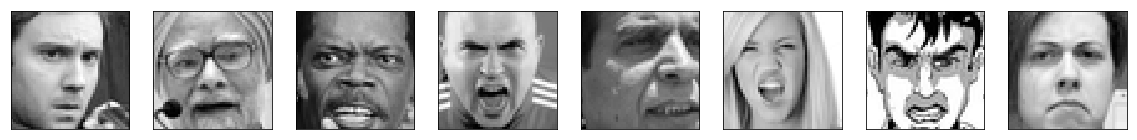

In [130]:
print_img(row=1, col=8, target=X_train3, idx=[0, 1, 2, 3, 4, 5, 6, 7])

In [142]:
Y_train3[19000:19010]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [117]:
%%time
np.savetxt('../dataset/face/X_train2.txt', X_train3.reshape((50372, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_train2.txt', Y_train3, delimiter=',')

CPU times: user 1min 38s, sys: 2.04 s, total: 1min 40s
Wall time: 1min 44s
